In [21]:
import pandas
import matplotlib.pyplot as plt

In [2]:
tables = pandas.read_html('https://en.wikipedia.org/wiki/List_of_oil_spills')

In [3]:
def robust_float(x):
    try:
        return float(x)
    except ValueError:
        return float('nan')

In [4]:
tonnes = tables[0]['Max Tonnes'].apply(robust_float)

In [5]:
import re

In [6]:
y = tables[0]['Dates'].apply(lambda x: int(re.search('\d{4}', x).group()))

In [7]:
total_tonnes = tonnes.groupby(y).sum()

In [8]:
total_tonnes = total_tonnes[total_tonnes.index > 1970]

<AxesSubplot:xlabel='Dates'>

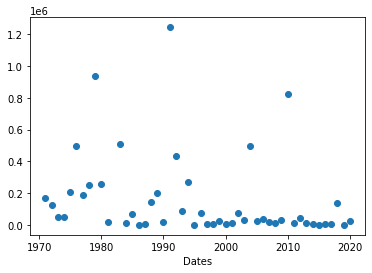

In [9]:
total_tonnes.plot(marker='o', ls='')

In [10]:
spills = y.groupby(y).size()

In [11]:
spills = spills[spills.index > 1970]

<AxesSubplot:xlabel='Dates'>

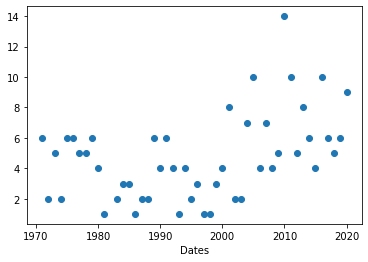

In [12]:
spills.plot(marker='o', ls='')

In [13]:
years = spills.index

In [14]:
import tensorflow as tf
import tensorflow_probability as tfp

tfd = tfp.distributions

In [30]:
def spill_count_model(rate_fn):
    count_model = tfd.JointDistributionNamed({
        "e": tfd.Exponential(rate=1.0),
        "l": tfd.Exponential(rate=5.0),
        "s": tfd.Uniform(float(years.min()), float(years.max())),
        "d_t": lambda s, l, e: tfd.Independent(
            tfd.Poisson(rate = rate_fn(
                tf.constant(years, dtype=tf.float32),
                s[...,tf.newaxis], l[...,tf.newaxis], e[...,tf.newaxis])
            ),
        reinterpreted_batch_ndims=1)
    })
    return count_model

In [16]:
tf.where([True, True, False], 1, 12)

<tf.Tensor: shape=(3,), dtype=int32, numpy=array([ 1,  1, 12], dtype=int32)>

In [17]:
def rate_fn_switch(years, s, l, e):
    return tf.where(years < s, e, l)

In [18]:
def rate_fn_sigmoid(years, s, l, e):
    return e + tf.sigmoid(years - s) * (l - e)

In [19]:
rate_fn_switch(years, 1990, 10, 1)

<tf.Tensor: shape=(49,), dtype=int32, numpy=
array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
      dtype=int32)>

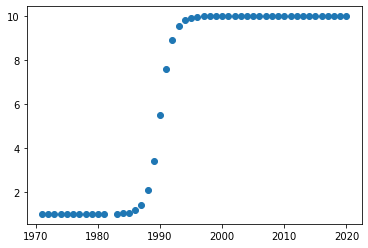

In [22]:
plt.plot(years, rate_fn_sigmoid(years, 1990., 10, 1).numpy(), marker='o', ls='')

In [23]:
model_sigmoid = spill_count_model(rate_fn_sigmoid)

In [24]:
model_sigmoid.resolve_graph()

(('s', ()), ('l', ()), ('e', ()), ('d_t', ('s', 'l', 'e')))

In [25]:
import matplotlib.pyplot as plt

In [31]:
model_sigmoid.sample()

{'s': <tf.Tensor: shape=(), dtype=float32, numpy=1985.3718>,
 'l': <tf.Tensor: shape=(), dtype=float32, numpy=0.1719291>,
 'e': <tf.Tensor: shape=(), dtype=float32, numpy=0.10839252>,
 'd_t': <tf.Tensor: shape=(49,), dtype=float32, numpy=
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.],
       dtype=float32)>}

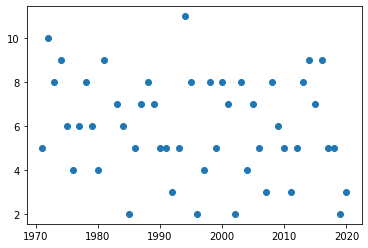

In [34]:
plt.plot(years, model_sigmoid.sample()['d_t'], marker='o', ls='')

In [40]:
def target_log_prob(s, e, l):
    return model_sigmoid.log_prob(s=s, e=e, l=l, d_t=spills)

In [42]:
target_log_prob(2000, 4, 8) # P(s, e, l| data)

<tf.Tensor: shape=(), dtype=float32, numpy=-127.27393>

In [44]:
tfb = tfp.bijectors

@tf.function
def make_chain(target_log_prob, n_chains, num_results, num_burin_steps):
    kernel = tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=target_log_prob,
        step_size=0.05,
        num_leapfrog_steps=3
    )
    states = tfp.mcmc.sample_chain(
        num_results=num_results,
        num_burnin_steps=num_burin_steps,
        kernel=kernel,
        current_state=[
            tfd.Uniform(float(years.min()), float(years.max())).sample(n_chains),
            tf.ones([n_chains]), # TODO: Randomize
            tf.ones([n_chains]) # TODO: Randomizee
        ]
    )
    return states

In [46]:
samples = make_chain(target_log_prob, 4, 10000, 3000)

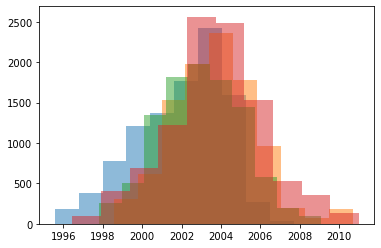

In [55]:
for i in range(4):
    plt.hist(samples[0][0][:,i].numpy(), alpha=0.5)

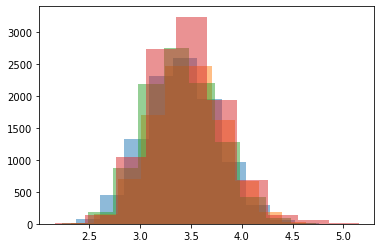

In [56]:
for i in range(4):
    plt.hist(samples[0][1][:,i].numpy(), alpha=0.5)

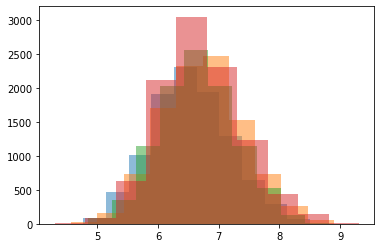

In [57]:
for i in range(4):
    plt.hist(samples[0][2][:,i].numpy(), alpha=0.5)

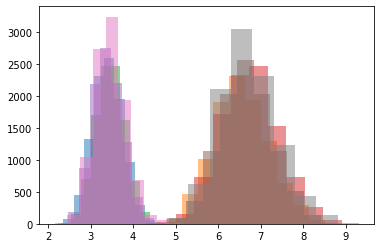

In [58]:
for i in range(4):
    plt.hist(samples[0][1][:,i].numpy(), alpha=0.5)
    plt.hist(samples[0][2][:,i].numpy(), alpha=0.5)

In [61]:
for i, name in enumerate(['switchpoint', 'early rate', 'late rate']):
    print(f"Rhat for {name}: {tfp.mcmc.potential_scale_reduction(samples[0][i])}")

Rhat for switchpoint: 1.1700975894927979
Rhat for early rate: 1.014410138130188
Rhat for late rate: 1.025351881980896


In [62]:
?tfp.mcmc.potential_scale_reduction

Signature:
tfp.mcmc.potential_scale_reduction(
    chains_states,
    independent_chain_ndims=1,
    split_chains=False,
    validate_args=False,
    name=None,
)
Docstring:
Gelman and Rubin (1992)'s potential scale reduction for chain convergence.

Given `N > 1` states from each of `C > 1` independent chains, the potential
scale reduction factor, commonly referred to as R-hat, measures convergence of
the chains (to the same target) by testing for equality of means.
Specifically, R-hat measures the degree to which variance (of the means)
between chains exceeds what one would expect if the chains were identically
distributed. See [Gelman and Rubin (1992)][1]; [Brooks and Gelman (1998)][2].

Some guidelines:

* The initial state of the chains should be drawn from a distribution
  overdispersed with respect to the target.
* If all chains converge to the target, then as `N --> infinity`, R-hat --> 1.
  Before that, R-hat > 1 (except in pathological cases, e.g. if the chain
  paths were ide